In [168]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
#notes
#time period: 2016/01/31-2018/12/31

#datasets
#Cab_Data.csv
#Customer_ID.csv
#Transaction_ID.csv
#City.csv

In [312]:
cab = pd.read_csv("Cab_Data.csv")
customer = pd.read_csv("Customer_ID.csv")
transaction = pd.read_csv("Transaction_ID.csv")
city = pd.read_csv("City.csv")

In [30]:
#check total data
print(len(cab))
print(len(customer))
print(len(transaction))
print(len(city))

359392
49171
440098
20


In [289]:
#check unique values
cab_uno = cab.drop_duplicates().shape[0]
customer_uno = customer.drop_duplicates().shape[0]
transaction_uno = transaction.drop_duplicates().shape[0]
print(cab_uno)
print(customer_uno)
print(transaction_uno)

359392
49171
440098


In [290]:
#check if there are missing data
print(cab.isin(['N/A']).any().any())
print(customer.isin(['N/A']).any().any())
print(transaction.isin(['N/A']).any().any())
print(cab.isin(['N/A']).any().any())

False
False
False
False


In [291]:
#no missing value and all unique ID number
#try to find out the difference between transaction ID and cab data
#left merge
merge_left = pd.merge(transaction, cab, on='Transaction ID', how = 'left')
missing_cab_data = merge_left[merge_left['Company'].isnull()]
missing_cab_data

,Transaction ID,Customer ID,Payment_Mode,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
192,10000203,43177,Card,NaN,NaN,NaN,NaN,NaN,NaN
193,10000204,44348,Cash,NaN,NaN,NaN,NaN,NaN,NaN
194,10000205,44599,Cash,NaN,NaN,NaN,NaN,NaN,NaN
195,10000206,44264,Cash,NaN,NaN,NaN,NaN,NaN,NaN
196,10000207,43369,Cash,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
440067,10440078,51612,Cash,NaN,NaN,NaN,NaN,NaN,NaN
440080,10440091,53963,Card,NaN,NaN,NaN,NaN,NaN,NaN
440091,10440102,52526,Cash,NaN,NaN,NaN,NaN,NaN,NaN
440092,10440103,53171,Card,NaN,NaN,NaN,NaN,NaN,NaN


In [292]:
#inner merge
merge_cab = pd.merge(cab, transaction, on='Transaction ID')
merge_cab

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,27703,Card
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.6320,28712,Cash
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.6020,28020,Cash
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.7760,27182,Card
...,...,...,...,...,...,...,...,...,...
359387,10440101,43108,Yellow Cab,WASHINGTON DC,4.80,69.24,63.3600,52392,Cash
359388,10440104,43104,Yellow Cab,WASHINGTON DC,8.40,113.75,106.8480,53286,Cash
359389,10440105,43105,Yellow Cab,WASHINGTON DC,27.75,437.07,349.6500,52265,Cash
359390,10440106,43105,Yellow Cab,WASHINGTON DC,8.80,146.19,114.0480,52175,Card


In [293]:
#merge for master data
data = pd.merge(merge_cab, customer, on='Customer ID', how = 'left')

In [294]:
#check for null and duplicates
data.isnull().any()
data.duplicated().any()
data.duplicated(subset=['Transaction ID', 'Customer ID']).any()

False

In [295]:
data['Profit'] = data['Price Charged'] - data['Cost of Trip']

In [296]:
#change date
#only use 42398 to 43463 for 2016/1/31-2018/12/31
data['Date of Travel'] = pd.to_datetime('1899-12-30') + pd.to_timedelta(data['Date of Travel'], unit='D')
data['Year'] = data['Date of Travel'].dt.year
data_1 = data.loc[(data['Date of Travel'] >= pd.to_datetime('2016-01-31')) &
                     (data['Date of Travel'] <= pd.to_datetime('2018-12-31'))]



In [297]:
data_1

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Profit,Year
3303,10004263,2016-02-02,Pink Cab,ATLANTA GA,25.07,355.29,285.7980,29170,Cash,Male,40,11777,69.4920,2016
3311,10004271,2016-02-01,Pink Cab,BOSTON MA,38.61,358.05,405.4050,59321,Cash,Male,45,22849,-47.3550,2016
3321,10004281,2016-01-31,Pink Cab,CHICAGO IL,30.69,406.90,349.8660,5323,Card,Male,33,20049,57.0340,2016
3343,10004303,2016-02-01,Pink Cab,CHICAGO IL,25.68,347.96,264.5040,4036,Cash,Male,40,9346,83.4560,2016
3345,10004305,2016-01-31,Pink Cab,CHICAGO IL,28.00,416.11,327.6000,5826,Card,Male,31,31812,88.5100,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359387,10440101,2018-01-08,Yellow Cab,WASHINGTON DC,4.80,69.24,63.3600,52392,Cash,Male,24,15651,5.8800,2018
359388,10440104,2018-01-04,Yellow Cab,WASHINGTON DC,8.40,113.75,106.8480,53286,Cash,Male,32,6528,6.9020,2018
359389,10440105,2018-01-05,Yellow Cab,WASHINGTON DC,27.75,437.07,349.6500,52265,Cash,Male,56,7966,87.4200,2018
359390,10440106,2018-01-05,Yellow Cab,WASHINGTON DC,8.80,146.19,114.0480,52175,Card,Male,32,6423,32.1420,2018


In [298]:
#Total difference
#chart overview
mean_profit = data_1.groupby('Company').agg({'Transaction ID': 'count', 'Profit': 'sum'})
mean_profit = mean_profit.rename(columns={'Transaction ID': 'Total Rides', 'Profit':'Total Profit'})
mean_profit['Profit Per Ride'] = mean_profit['Total Profit']/mean_profit['Total Rides']
mean_profit['Total Profit'] = mean_profit['Total Profit'].apply(lambda x: "{:.0f}".format(x))
mean_profit['Bad Trip'] = data_1[data_1['Profit'] < 0].groupby('Company')['Profit'].count()

mean_profit


,Total Rides,Total Profit,Profit Per Ride,Bad Trip
Company,,,,
Pink Cab,83825,5237540,62.481840,10989
Yellow Cab,271207,43251775,159.478831,13669


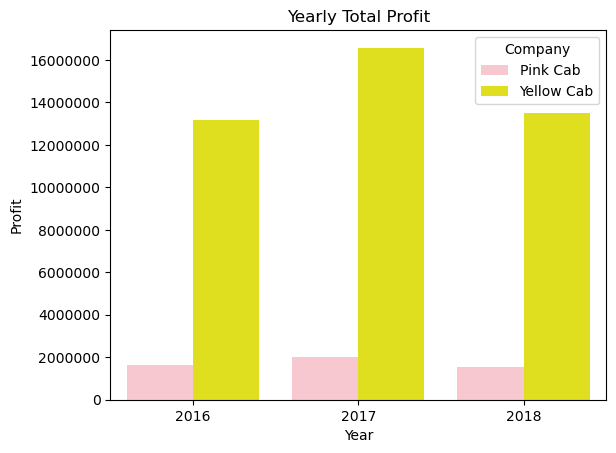

In [299]:
#profit year
year_profit = data_1.groupby(['Company', 'Year'])['Profit'].sum().reset_index()

sns.barplot(x='Year', y='Profit', hue='Company', data=year_profit, palette=['pink', 'yellow'])
plt.xlabel('Year')
plt.ylabel('Profit')
plt.title('Yearly Total Profit')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

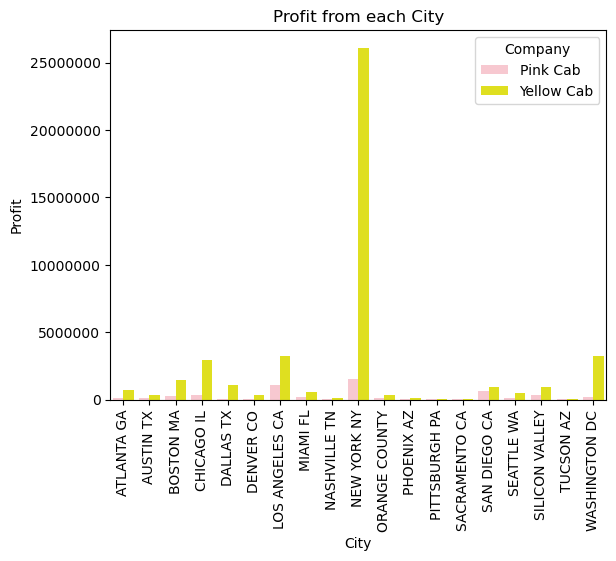

In [300]:
#city profit
city_profit = data_1.groupby(['Company', 'City'])['Profit'].sum().reset_index()

sns.barplot(x='City', y='Profit', hue='Company', data=city_profit, palette=['pink', 'yellow'])
plt.xlabel('City')
plt.ylabel('Profit')
plt.title('Profit from each City')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.show()

In [301]:
#city user percentage
city['Users'] = city['Users'].str.replace(',', '').str.strip().astype(int)
city['Population'] = city['Population'].str.replace(',', '').str.strip().astype(int)
user_percentage = city.groupby('City')['Users'].sum() / city.groupby('City')['Population'].sum()
user_percentage = user_percentage.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.xlabel('City')
plt.ylabel('User %')
plt.title('User % for each city')
plt.xticks(rotation=90)

user_percentage.plot(kind='bar')
plt.show()

AttributeError: Can only use .str accessor with string values!

In [ ]:
#number of customer in each city for both company








In [ ]:
#company gender wise analysis
gender = data_1.groupby(['Company', 'Gender'])['Transaction ID'].count().reset_index()
gender = gender.rename(columns={'Transaction ID': 'Total'})

plt.figure(figsize=(8, 6))
ax1 = sns.barplot(x='Gender', y='Total', hue='Company', data=gender, palette=['pink', 'yellow'])
plt.xlabel('Gender')
plt.ylabel('Total')
plt.title('Gender Wise Analysis')

plt.show()


#for index, row in gender.iterrows():
    #plt.text(row.name, row['Total'], str(row['Total']), ha='center', va='bottom')
 

/var/folders/1f/jl4ws2hd35s8hqzrng2b9b600000gn/T/ipykernel_29565/2613100351.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['Income Category'] = pd.cut(data_1['Income (USD/Month)'], bins=income_ranges, labels=income_labels, right=False)


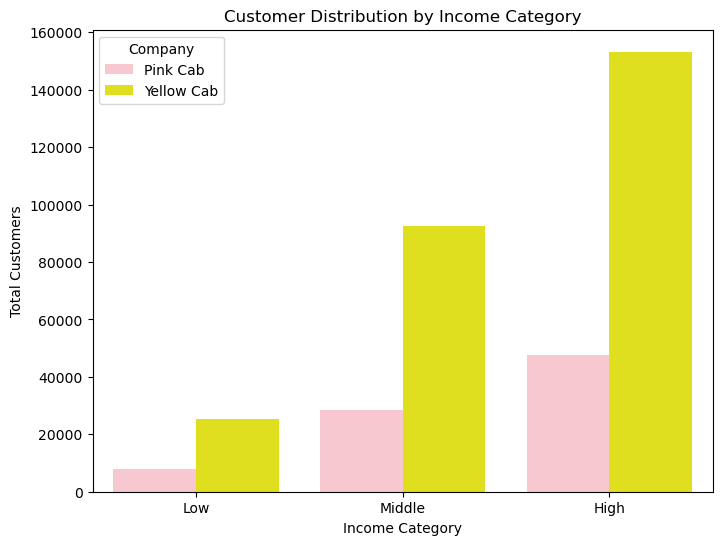

In [302]:
#customer income
#income status:  0~4350~13050 as Low, Middle, High

income_ranges = [0, 4350, 13050, np.inf]
income_labels = ['Low', 'Middle', 'High']
data_1['Income Category'] = pd.cut(data_1['Income (USD/Month)'], bins=income_ranges, labels=income_labels, right=False)

customer_groups = data_1.groupby(['Company', 'Income Category'])['Customer ID'].count().reset_index()
customer_groups = customer_groups.rename(columns={'Customer ID': 'Total Customers'})

plt.figure(figsize=(8, 6))
sns.barplot(x='Income Category', y='Total Customers', hue='Company', data=customer_groups, palette=['pink', 'yellow'])
plt.xlabel('Income Category')
plt.ylabel('Total Customers')
plt.title('Customer Distribution by Income Category')

plt.show()

/var/folders/1f/jl4ws2hd35s8hqzrng2b9b600000gn/T/ipykernel_29565/574444841.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['Age Category'] = pd.cut(data_1['Age'], bins=age_ranges, labels=age_labels, right=False)


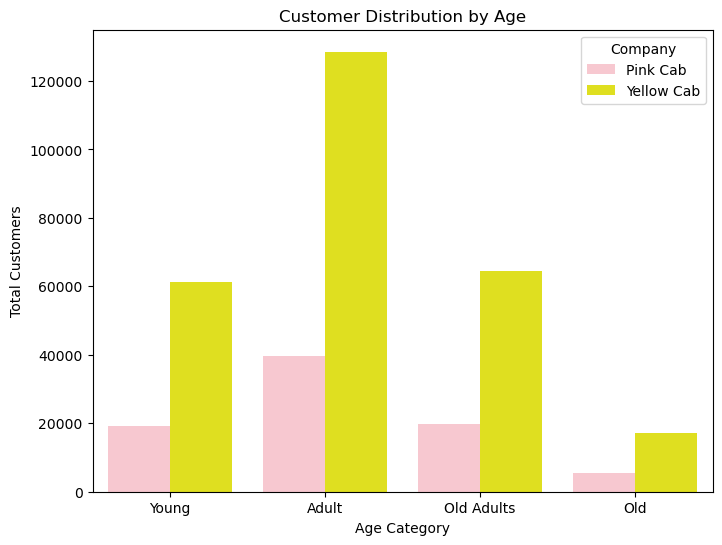

In [303]:
#company age gender
#18-25, 26-40, 41-60, 60+
age_ranges = [18, 25, 40, 60, np.inf]
age_labels = ['Young', 'Adult', 'Old Adults', 'Old']
data_1['Age Category'] = pd.cut(data_1['Age'], bins=age_ranges, labels=age_labels, right=False)

age_groups = data_1.groupby(['Company', 'Age Category'])['Customer ID'].count().reset_index()
age_groups = age_groups.rename(columns={'Customer ID': 'Total Customers'})

plt.figure(figsize=(8, 6))
sns.barplot(x='Age Category', y='Total Customers', hue='Company', data=age_groups, palette=['pink', 'yellow'])
plt.xlabel('Age Category')
plt.ylabel('Total Customers')
plt.title('Customer Distribution by Age')

plt.show()

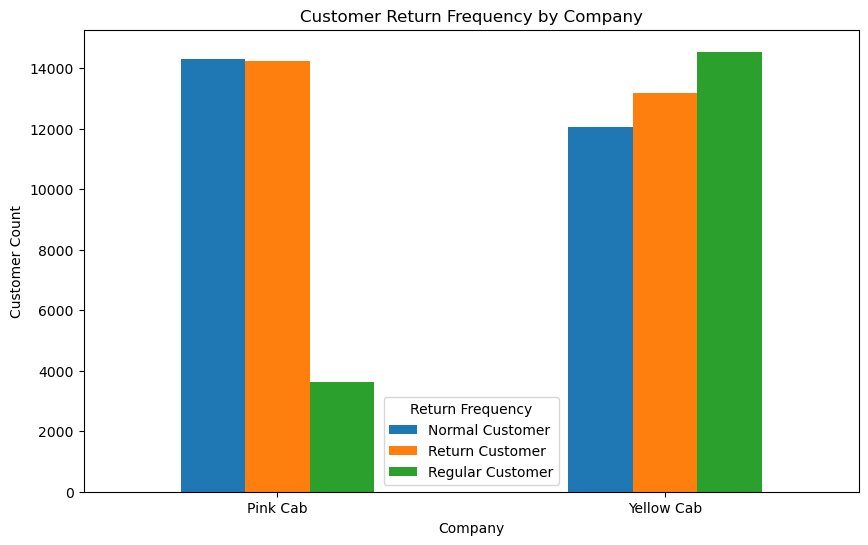

In [304]:
#customer return (2 times up, 10 times up) (regular customer)
customer_counts = data_1.groupby(['Company', 'Customer ID']).size().reset_index(name='Count')

customer_counts['Return Frequency'] = pd.cut(customer_counts['Count'],
                                             bins=[0, 1, 5, float('inf')],
                                             labels=['Normal Customer', 'Return Customer', 'Regular Customer'])

return_frequency_counts = customer_counts.groupby(['Company', 'Return Frequency']).size().reset_index(name='Customer Count')
return_frequency_pivot = return_frequency_counts.pivot(index='Company', columns='Return Frequency', values='Customer Count')
return_frequency_pivot.fillna(0, inplace=True)
return_frequency_pivot.plot(kind='bar', figsize=(10, 6),)

plt.xlabel('Company')
plt.ylabel('Customer Count')
plt.title('Customer Return Frequency by Company')
plt.xticks(rotation=0)
plt.show()

In [305]:
#seasonality in demand


In [306]:
#seasonality in profit

/var/folders/1f/jl4ws2hd35s8hqzrng2b9b600000gn/T/ipykernel_29565/1833992346.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['Month'] = data_1['Date of Travel'].dt.month


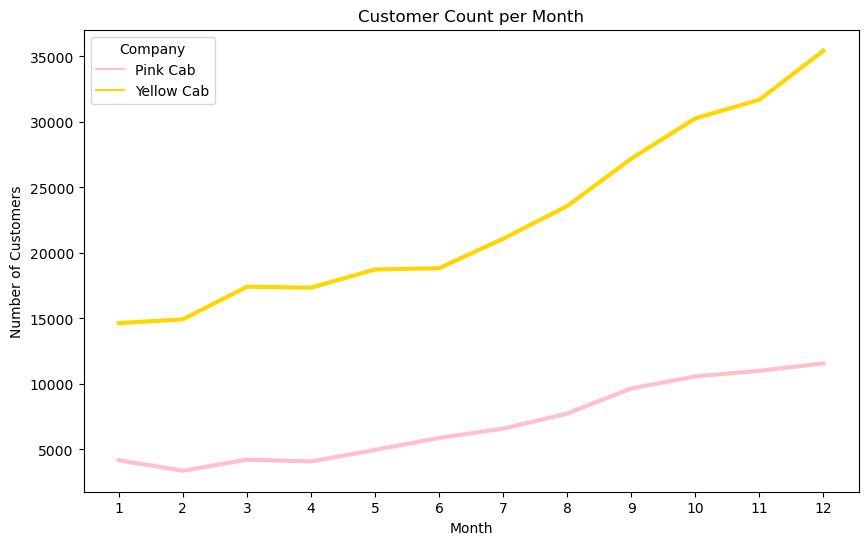

In [307]:
#customer ride monthly pattern
data_1['Month'] = data_1['Date of Travel'].dt.month

monthly_count = data_1.groupby(['Company', 'Month'])['Customer ID'].count().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='Month', y='Customer ID', hue='Company', data=monthly_count, 
             palette=['pink', '#FFD700'], linewidth = 3)
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.title('Customer Count per Month')
plt.xticks(range(1, 13))
plt.show()

In [308]:
#customer ride daily pattern

data_1['Day'] = data_1['Date of Travel'].dt.day

day_count = data.groupby(['Month', 'Day'])['Customer_ID'].nunique().reset_index()

/var/folders/1f/jl4ws2hd35s8hqzrng2b9b600000gn/T/ipykernel_29565/320816432.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['Day'] = data_1['Date of Travel'].dt.day


KeyError: 'Month'

/var/folders/1f/jl4ws2hd35s8hqzrng2b9b600000gn/T/ipykernel_29565/2489439115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['Week'] = data_1['Date of Travel'].dt.day_name()


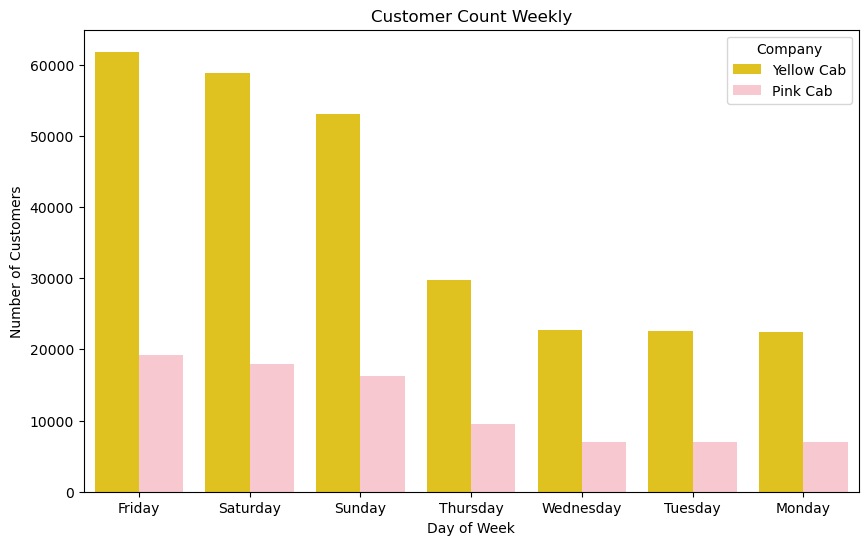

In [309]:
#customer ride weekly pattern
data_1['Week'] = data_1['Date of Travel'].dt.day_name()
week_count = data_1.groupby(['Company', 'Week'])['Transaction ID'].count().reset_index()
week_count = week_count.sort_values( 'Transaction ID', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Week', y='Transaction ID', hue='Company', data=week_count, 
             palette=['#FFD700', 'pink'], linewidth = 3)
plt.xlabel('Day of Week')
plt.ylabel('Number of Customers')
plt.title('Customer Count Weekly')
plt.show()


In [310]:
data_1['Week'].value_counts()['Sunday']


69307

/var/folders/1f/jl4ws2hd35s8hqzrng2b9b600000gn/T/ipykernel_29565/3582093161.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['KM Category'] = pd.cut(data_1['KM Travelled'], bins=km_ranges, labels=km_labels, right=False)


Text(0.5, 1.0, 'Customer Distribution by Travelled Distance')

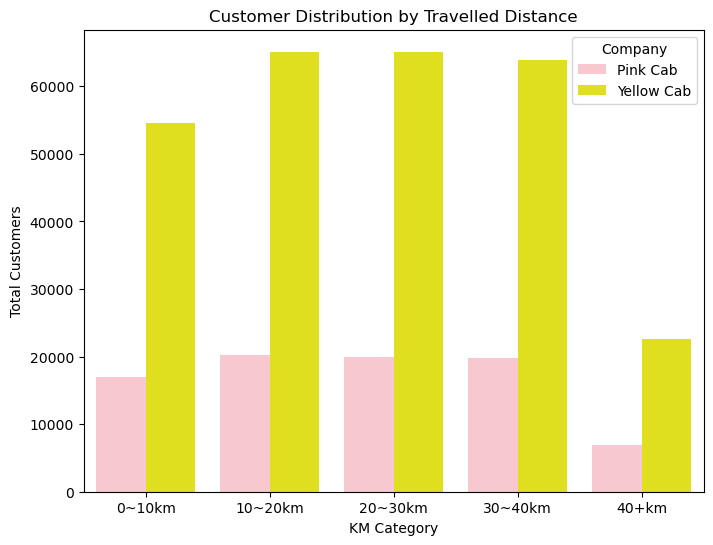

In [311]:
#customer distance
km_ranges = [0, 10, 20, 30, 40, np.inf]
km_labels = ['0~10km', '10~20km', '20~30km', '30~40km', '40+km']
data_1['KM Category'] = pd.cut(data_1['KM Travelled'], bins=km_ranges, labels=km_labels, right=False)

km_groups = data_1.groupby(['Company', 'KM Category'])['Customer ID'].count().reset_index()
km_groups = km_groups.rename(columns={'Customer ID': 'Total Customers'})

plt.figure(figsize=(8, 6))
sns.barplot(x='KM Category', y='Total Customers', hue='Company', data=km_groups, palette=['pink', 'yellow'])
plt.xlabel('KM Category')
plt.ylabel('Total Customers')
plt.title('Customer Distribution by Travelled Distance')

